In [20]:
# ============================================================
# 04_Multimodal_TabDropout_BlindTest.ipynb
# ============================================================
# NB04_ImageOnly_Multimodal_BlindTest.ipynb

import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import r2_score

from tqdm import tqdm
import matplotlib.pyplot as plt

# Paths (ajuste se necessário)
BASE_DIR = Path(".")
TRAIN_CSV = BASE_DIR / "train.csv"
EMB_CSV   = BASE_DIR / "embeddings" / "image_embeddings.csv"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [21]:
# -----------------------------
# Carregar train
# -----------------------------
train = pd.read_csv(TRAIN_CSV)

# Garantir tipo de data
if not np.issubdtype(train["Sampling_Date"].dtype, np.datetime64):
    train["Sampling_Date"] = pd.to_datetime(train["Sampling_Date"])

# ID simples da imagem
train["image_id"] = train["image_path"].str.extract(r"(ID\d+)")

# Features temporais a partir da Sampling_Date
train["month"]  = train["Sampling_Date"].dt.month
train["Season"] = train["Sampling_Date"].dt.month % 12 // 3 + 1

# Targets principais (biomassa)
target_order = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

# Índice para pivot (uma linha por imagem)
pivot_index_cols = [
    "image_id",
    "image_path",
    "Sampling_Date",
    "State",
    "Species",
    "Pre_GSHH_NDVI",
    "Height_Ave_cm",
    "month",
    "Season",
]

# wide: 1 linha por imagem, 5 targets
wide = (
    train
    .pivot_table(
        index=pivot_index_cols,
        columns="target_name",
        values="target"
    )
    .reset_index()
)

wide = wide[pivot_index_cols + target_order]
print("Wide shape (antes dos embeddings):", wide.shape)
wide.head()
    

Wide shape (antes dos embeddings): (357, 14)


target_name,image_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,month,Season,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,9,4,0.0000,31.9984,16.2751,48.2735,16.2750
1,ID1012260530,train/ID1012260530.jpg,2015-04-01,NSW,Lucerne,0.55,16.0000,4,2,0.0000,0.0000,7.6000,7.6000,7.6000
2,ID1025234388,train/ID1025234388.jpg,2015-09-01,WA,SubcloverDalkeith,0.38,1.0000,9,4,6.0500,0.0000,0.0000,6.0500,6.0500
3,ID1028611175,train/ID1028611175.jpg,2015-05-18,Tas,Ryegrass,0.66,5.0000,5,2,0.0000,30.9703,24.2376,55.2079,24.2376
4,ID1035947949,train/ID1035947949.jpg,2015-09-11,Tas,Ryegrass,0.54,3.5000,9,4,0.4343,23.2239,10.5261,34.1844,10.9605


In [22]:
# -----------------------------
# Carregar embeddings
# -----------------------------
emb = pd.read_csv(EMB_CSV)
print("Embeddings shape:", emb.shape)

# Garante image_id nos embeddings
if "image_id" not in emb.columns:
    emb["image_id"] = emb["image_path"].str.extract(r"(ID\d+)")

emb_cols = [c for c in emb.columns if c.startswith("emb_")]
print("N embedding dims:", len(emb_cols))

# Merge wide + embeddings
wide = wide.merge(
    emb[["image_id"] + emb_cols],
    on="image_id",
    how="left"
)

# Tratar NaNs em embeddings (dropar é mais simples e seguro)
missing_emb = wide[emb_cols].isna().sum().sum()
print("Missing embeddings:", missing_emb)

if missing_emb > 0:
    wide = wide.dropna(subset=emb_cols).reset_index(drop=True)

print("Wide shape (com embeddings):", wide.shape)
wide.head()


Embeddings shape: (357, 51)
N embedding dims: 50
Missing embeddings: 0
Wide shape (com embeddings): (357, 64)


,image_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,month,Season,Dry_Clover_g,...,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49
0,ID1011485656,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,9,4,0.0000,...,0.117874,0.223127,0.047788,0.217218,-0.068581,-0.662873,-0.092597,-0.204535,-0.212134,0.174599
1,ID1012260530,train/ID1012260530.jpg,2015-04-01,NSW,Lucerne,0.55,16.0000,4,2,0.0000,...,-0.040193,-0.259712,0.072441,0.515180,0.470040,-0.027654,0.063274,-0.762259,0.184141,0.172425
2,ID1025234388,train/ID1025234388.jpg,2015-09-01,WA,SubcloverDalkeith,0.38,1.0000,9,4,6.0500,...,-0.209841,0.829134,-1.185501,0.452218,0.562699,-0.649432,0.476196,0.337699,0.291902,0.482889
3,ID1028611175,train/ID1028611175.jpg,2015-05-18,Tas,Ryegrass,0.66,5.0000,5,2,0.0000,...,0.267399,-0.845540,-0.458251,-0.025703,-0.262439,-0.491392,0.801272,-0.684913,0.111406,0.012976
4,ID1035947949,train/ID1035947949.jpg,2015-09-11,Tas,Ryegrass,0.54,3.5000,9,4,0.4343,...,0.194924,-0.646429,0.926227,0.537783,-0.150664,-0.118666,0.276410,0.135461,0.043913,0.219535


In [23]:
# -------------------------------------------------
# Definir colunas auxiliares
# -------------------------------------------------
aux_num_cols = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
aux_cat_cols = ["month", "Season", "State", "Species"]

# Vamos criar códigos inteiros para as variáveis categóricas auxiliares
cat_label_maps = {}     # para inspeção, se quiser
for col in aux_cat_cols:
    wide[col] = wide[col].astype("category")
    cat_label_maps[col] = {
        "categories": list(wide[col].cat.categories),
        "name": col,
    }
    wide[col + "_code"] = wide[col].cat.codes.astype("int64")  # -1 se NaN, mas não deve ter

# Número de classes em cada categórica
n_classes = {
    col: wide[col + "_code"].max() + 1
    for col in aux_cat_cols
}

n_classes


{'month': 10, 'Season': 4, 'State': 4, 'Species': 15}

In [24]:
class PastureImageOnlyDataset(Dataset):
    """
    Dataset:
      - X: embeddings de imagem (somente)
      - y_biom: 5 targets de biomassa
      - y_aux_num: NDVI, Height (float)
      - y_aux_cat: month, Season, State, Species (códigos inteiros)
    """
    def __init__(self, wide_df, emb_cols, target_order, aux_num_cols, aux_cat_cols):
        self.X = torch.tensor(
            wide_df[emb_cols].values.astype("float32"),
            dtype=torch.float32
        )
        self.y_biom = torch.tensor(
            wide_df[target_order].values.astype("float32"),
            dtype=torch.float32
        )
        self.y_aux_num = torch.tensor(
            wide_df[aux_num_cols].values.astype("float32"),
            dtype=torch.float32
        )
        # cada categórica vira um tensor 1D de long
        self.y_aux_cat = {}
        for col in aux_cat_cols:
            code_col = col + "_code"
            self.y_aux_cat[col] = torch.tensor(
                wide_df[code_col].values.astype("int64"),
                dtype=torch.long
            )

        self.aux_cat_cols = aux_cat_cols

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # devolve tudo para treino
        x_img = self.X[idx]
        y_biom = self.y_biom[idx]
        y_aux_num = self.y_aux_num[idx]
        y_aux_cat = {col: self.y_aux_cat[col][idx] for col in self.aux_cat_cols}
        return x_img, y_biom, y_aux_num, y_aux_cat



In [25]:
class ImageOnlyMultitaskNet(nn.Module):
    def __init__(
        self,
        img_dim,
        n_aux_num=2,
        n_classes_dict=None,
        hidden=256,
        dropout=0.2,
    ):
        super().__init__()

        if n_classes_dict is None:
            raise ValueError("n_classes_dict must be provided.")

        # Backbone a partir dos embeddings
        self.backbone = nn.Sequential(
            nn.Linear(img_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.GELU(),
        )

        # Head principal: biomassa (5 targets)
        self.head_biom = nn.Linear(hidden, 5)

        # Head auxiliar numérica: NDVI, Height
        self.head_aux_num = nn.Linear(hidden, n_aux_num)

        # Heads auxiliares categóricas
        self.head_month  = nn.Linear(hidden, n_classes_dict["month"])
        self.head_season = nn.Linear(hidden, n_classes_dict["Season"])
        self.head_state  = nn.Linear(hidden, n_classes_dict["State"])
        self.head_species = nn.Linear(hidden, n_classes_dict["Species"])

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x_img):
        h = self.backbone(x_img)

        out = {
            "biom": self.head_biom(h),            # (B,5)
            "aux_num": self.head_aux_num(h),      # (B,2)
            "month_logits":  self.head_month(h),  # (B, n_month)
            "season_logits": self.head_season(h),
            "state_logits":  self.head_state(h),
            "species_logits": self.head_species(h),
        }
        return out


In [26]:
def rmse_np(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def weighted_r2_score(y_true, y_pred, weights_dict):
    # y_true/pred: (N, 5)
    w = np.array([weights_dict[k] for k in target_order], dtype=np.float32)

    y_mean = np.mean(y_true, axis=0)          # mean por target
    y_wmean = np.sum(w * y_mean) / np.sum(w)  # média global ponderada

    ss_res = np.sum(w * np.sum((y_true - y_pred) ** 2, axis=0))
    ss_tot = np.sum(w * np.sum((y_true - y_wmean) ** 2, axis=0))

    return 1.0 - ss_res / ss_tot


weights_dict = {
    "Dry_Clover_g": 0.1,
    "Dry_Dead_g":   0.1,
    "Dry_Green_g":  0.1,
    "Dry_Total_g":  0.5,
    "GDM_g":        0.2
}


def compute_loss(outputs, y_biom, y_aux_num, y_aux_cat, alpha_aux=0.0):
    """
    outputs: dict do modelo
    y_biom: (B,5)
    y_aux_num: (B,2)
    y_aux_cat: dict com tensores long: month, Season, State, Species
    alpha_aux: peso dos termos auxiliares. 
               Se 0.0 → apenas biomassa treina (sua escolha A e 2).
    """
    mse = nn.MSELoss()
    ce  = nn.CrossEntropyLoss()

    # loss principal: biomassa
    loss_biom = mse(outputs["biom"], y_biom)

    if alpha_aux <= 0.0:
        return loss_biom, {"loss_biom": loss_biom.item()}

    # auxiliares numéricos
    loss_aux_num = mse(outputs["aux_num"], y_aux_num)

    # auxiliares categóricos
    loss_month   = ce(outputs["month_logits"],  y_aux_cat["month"])
    loss_season  = ce(outputs["season_logits"], y_aux_cat["Season"])
    loss_state   = ce(outputs["state_logits"],  y_aux_cat["State"])
    loss_species = ce(outputs["species_logits"],y_aux_cat["Species"])

    loss_aux_cat = (loss_month + loss_season + loss_state + loss_species) / 4.0

    loss_total = loss_biom + alpha_aux * (loss_aux_num + loss_aux_cat)

    log_dict = {
        "loss_biom": loss_biom.item(),
        "loss_aux_num": loss_aux_num.item(),
        "loss_aux_cat": loss_aux_cat.item(),
        "loss_total": loss_total.item(),
    }
    return loss_total, log_dict


In [27]:
def train_one_run(
    wide_train,
    *,
    emb_cols,
    target_order,
    aux_num_cols,
    aux_cat_cols,
    n_classes,
    alpha_aux=0.0,
    val_frac=0.2,
    epochs=50,
    patience=8,
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    verbose=True,
):
    """
    Treina um modelo usando apenas embeddings de imagem.
    Targets principais: biomassa.
    Targets auxiliares: tabulares, opcionais no loss (alpha_aux).
    """

    # ------------------------
    # Train/val split interno
    # ------------------------
    n = len(wide_train)
    idx_all = np.arange(n)
    idx_tr, idx_val = train_test_split(
        idx_all, test_size=val_frac, random_state=42
    )

    def make_dataset(df_subset):
        return PastureImageOnlyDataset(
            df_subset, emb_cols, target_order,
            aux_num_cols, aux_cat_cols
        )

    wide_tr  = wide_train.iloc[idx_tr].reset_index(drop=True)
    wide_val = wide_train.iloc[idx_val].reset_index(drop=True)

    ds_tr  = make_dataset(wide_tr)
    ds_val = make_dataset(wide_val)

    train_loader = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

    # ------------------------
    # Modelo
    # ------------------------
    img_dim = len(emb_cols)

    model = ImageOnlyMultitaskNet(
        img_dim=img_dim,
        n_aux_num=len(aux_num_cols),
        n_classes_dict=n_classes,
        hidden=256,
        dropout=0.2,
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    best_val = np.inf
    best_state = None
    wait = 0

    if verbose:
        print("\n=== Training one run (image-only) ===\n")

    epoch_bar = tqdm(range(1, epochs + 1), desc="Epochs")

    for epoch in epoch_bar:
        # ---- TRAIN ----
        model.train()
        train_loss = 0.0

        for x_img, y_biom, y_aux_num, y_aux_cat in train_loader:
            x_img     = x_img.to(device)
            y_biom    = y_biom.to(device)
            y_aux_num = y_aux_num.to(device)
            y_aux_cat_dev = {k: v.to(device) for k, v in y_aux_cat.items()}

            optimizer.zero_grad()
            outputs = model(x_img)
            loss, _ = compute_loss(
                outputs, y_biom, y_aux_num, y_aux_cat_dev,
                alpha_aux=alpha_aux
            )
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # ---- VAL ----
        model.eval()
        val_loss = 0.0
        preds_biom, targs_biom = [], []

        with torch.no_grad():
            for x_img, y_biom, y_aux_num, y_aux_cat in val_loader:
                x_img  = x_img.to(device)
                y_biom = y_biom.to(device)

                outputs = model(x_img)
                loss, _ = compute_loss(
                    outputs, y_biom,
                    y_aux_num=None,  # não importa para o loss se alpha_aux=0
                    y_aux_cat=None,
                    alpha_aux=0.0    # sempre biomassa only na avaliação
                )

                val_loss += loss.item()
                preds_biom.append(outputs["biom"].cpu().numpy())
                targs_biom.append(y_biom.cpu().numpy())

        val_loss /= len(val_loader)
        preds_biom = np.vstack(preds_biom)
        targs_biom = np.vstack(targs_biom)

        rmse_val = rmse_np(targs_biom, preds_biom)
        r2_val   = r2_score(targs_biom.ravel(), preds_biom.ravel())
        r2w_val  = weighted_r2_score(targs_biom, preds_biom, weights_dict)

        epoch_bar.set_postfix({
            "train_loss": f"{train_loss:.1f}",
            "val_loss":   f"{val_loss:.1f}",
            "RMSE":       f"{rmse_val:.2f}",
            "R2":         f"{r2_val:.3f}",
            "R2w":        f"{r2w_val:.3f}",
        })

        scheduler.step()

        # Early stopping
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            if verbose:
                print("\nEarly stopping.\n")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model


In [28]:
from sklearn.model_selection import train_test_split

def run_blind_experiments_image_only(
    wide,
    n_runs=5,
    blind_frac=0.2,
    alpha_aux=0.0,   # sua escolha A e 2 → 0.0 (apenas biomassa supervisiona)
    seed_base=42,
):
    results = []
    all_true = []
    all_pred = []

    n = len(wide)

    for run in range(n_runs):
        seed = seed_base + run
        rng = np.random.default_rng(seed)
        idx_all = np.arange(n)
        rng.shuffle(idx_all)

        blind_size = int(blind_frac * n)
        blind_idx = idx_all[:blind_size]
        train_idx = idx_all[blind_size:]

        wide_train = wide.iloc[train_idx].reset_index(drop=True)
        wide_blind = wide.iloc[blind_idx].reset_index(drop=True)

        # Treinar modelo na parte de treino
        model = train_one_run(
            wide_train,
            emb_cols=emb_cols,
            target_order=target_order,
            aux_num_cols=aux_num_cols,
            aux_cat_cols=aux_cat_cols,
            n_classes=n_classes,
            alpha_aux=alpha_aux,
            epochs=50,
            patience=8,
            verbose=True,
        )

        # Avaliação no blind
        ds_blind = PastureImageOnlyDataset(
            wide_blind, emb_cols, target_order, aux_num_cols, aux_cat_cols
        )
        loader_blind = DataLoader(ds_blind, batch_size=64, shuffle=False)

        model.eval()
        preds_blind = []
        targs_blind = []

        with torch.no_grad():
            for x_img, y_biom, y_aux_num, y_aux_cat in loader_blind:
                x_img  = x_img.to(device)
                y_biom = y_biom.to(device)

                outputs = model(x_img)
                preds_blind.append(outputs["biom"].cpu().numpy())
                targs_blind.append(y_biom.cpu().numpy())

        preds_blind = np.vstack(preds_blind)
        targs_blind = np.vstack(targs_blind)

        rmse_b = rmse_np(targs_blind, preds_blind)
        r2_b   = r2_score(targs_blind.ravel(), preds_blind.ravel())
        r2w_b  = weighted_r2_score(targs_blind, preds_blind, weights_dict)

        results.append({
            "run": run,
            "rmse":  rmse_b,
            "r2":    r2_b,
            "r2w":   r2w_b,
        })

        all_true.append(targs_blind)
        all_pred.append(preds_blind)

        print(f"\nRun {run}: RMSE={rmse_b:.2f}, R²={r2_b:.3f}, R²w={r2w_b:.3f}")

    results_df = pd.DataFrame(results)

    all_true = np.vstack(all_true)
    all_pred = np.vstack(all_pred)

    return results_df, all_true, all_pred


# ---- Rodar experimentos ----
results_df, all_true_img, all_pred_img = run_blind_experiments_image_only(
    wide,
    n_runs=10,
    blind_frac=0.2,
    alpha_aux=0.0,   # sua escolha A e 2
    seed_base=42,
)

results_df



=== Training one run (image-only) ===



Epochs:  58%|▌| 29/50 [00:00<00:00, 37.15it/s, train_loss=123.2, val_loss=203.8, RMSE=14.27, R2=0.62



Early stopping.


Run 0: RMSE=15.25, R²=0.573, R²w=0.532

=== Training one run (image-only) ===



Epochs:  88%|▉| 44/50 [00:00<00:00, 48.94it/s, train_loss=103.7, val_loss=232.3, RMSE=15.17, R2=0.70



Early stopping.


Run 1: RMSE=13.07, R²=0.730, R²w=0.689

=== Training one run (image-only) ===



Epochs:  72%|▋| 36/50 [00:00<00:00, 49.60it/s, train_loss=96.6, val_loss=222.5, RMSE=14.77, R2=0.726



Early stopping.


Run 2: RMSE=15.29, R²=0.644, R²w=0.600

=== Training one run (image-only) ===



Epochs:  78%|▊| 39/50 [00:00<00:00, 51.64it/s, train_loss=85.3, val_loss=275.8, RMSE=16.77, R2=0.703



Early stopping.


Run 3: RMSE=14.80, R²=0.614, R²w=0.565

=== Training one run (image-only) ===



Epochs:  74%|▋| 37/50 [00:00<00:00, 52.46it/s, train_loss=103.1, val_loss=222.8, RMSE=15.09, R2=0.64



Early stopping.


Run 4: RMSE=13.59, R²=0.662, R²w=0.620

=== Training one run (image-only) ===



Epochs:  64%|▋| 32/50 [00:00<00:00, 50.41it/s, train_loss=100.5, val_loss=183.8, RMSE=13.58, R2=0.72



Early stopping.


Run 5: RMSE=15.48, R²=0.627, R²w=0.576

=== Training one run (image-only) ===



Epochs:  66%|▋| 33/50 [00:00<00:00, 50.79it/s, train_loss=103.4, val_loss=236.0, RMSE=15.34, R2=0.65



Early stopping.


Run 6: RMSE=13.55, R²=0.767, R²w=0.753

=== Training one run (image-only) ===



Epochs:  66%|▋| 33/50 [00:00<00:00, 53.50it/s, train_loss=111.2, val_loss=117.4, RMSE=10.90, R2=0.76



Early stopping.


Run 7: RMSE=15.17, R²=0.700, R²w=0.670

=== Training one run (image-only) ===



Epochs:  64%|▋| 32/50 [00:00<00:00, 49.92it/s, train_loss=103.6, val_loss=188.1, RMSE=13.76, R2=0.70



Early stopping.


Run 8: RMSE=16.45, R²=0.666, R²w=0.638

=== Training one run (image-only) ===



Epochs:  76%|▊| 38/50 [00:00<00:00, 49.16it/s, train_loss=92.9, val_loss=241.4, RMSE=15.58, R2=0.686



Early stopping.


Run 9: RMSE=13.76, R²=0.609, R²w=0.552


,run,rmse,r2,r2w
0,0,15.250418,0.573295,0.532062
1,1,13.072201,0.729616,0.689056
2,2,15.293653,0.643647,0.599862
3,3,14.798038,0.613905,0.565030
4,4,13.587650,0.661821,0.620355
5,5,15.475796,0.627225,0.575932
6,6,13.554922,0.767258,0.752862
7,7,15.171152,0.700427,0.669609
8,8,16.445948,0.665944,0.638304
9,9,13.762086,0.608838,0.552311


Resultados médios em 10 rodadas:
run      4.500000
rmse    14.641186
r2       0.659198
r2w      0.619538
dtype: float64

== Métricas agregadas (image-only, todas rodadas) ==
RMSE: 14.6773
R² (global): 0.6669
Weighted R² (Kaggle): 0.6309


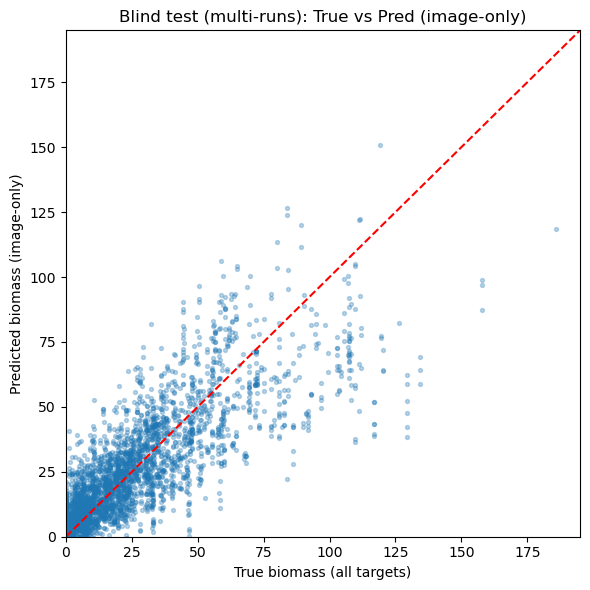


Salvo: blind_true_vs_pred_image_only.csv


In [29]:
print("Resultados médios em", len(results_df), "rodadas:")
print(results_df.mean())

rmse_global = rmse_np(all_true_img, all_pred_img)
r2_global   = r2_score(all_true_img.ravel(), all_pred_img.ravel())
r2w_global  = weighted_r2_score(all_true_img, all_pred_img, weights_dict)

print("\n== Métricas agregadas (image-only, todas rodadas) ==")
print(f"RMSE: {rmse_global:.4f}")
print(f"R² (global): {r2_global:.4f}")
print(f"Weighted R² (Kaggle): {r2w_global:.4f}")

# Scatter True vs Pred
plt.figure(figsize=(6,6))
plt.scatter(all_true_img.ravel(), all_pred_img.ravel(), alpha=0.3, s=8)
lims = [0, max(all_true_img.max(), all_pred_img.max())*1.05]
plt.plot(lims, lims, "r--")
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("True biomass (all targets)")
plt.ylabel("Predicted biomass (image-only)")
plt.title("Blind test (multi-runs): True vs Pred (image-only)")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Salvar pares verdade vs predito em CSV
# -------------------------------------------------
cols_true = [f"true_{t}" for t in target_order]
cols_pred = [f"pred_{t}" for t in target_order]

df_pairs = pd.DataFrame(
    np.hstack([all_true_img, all_pred_img]),
    columns=cols_true + cols_pred
)

df_pairs.to_csv("blind_true_vs_pred_image_only.csv", index=False)
print("\nSalvo: blind_true_vs_pred_image_only.csv")


In [32]:
import json

def train_and_save_image_only_ensemble(
    wide,
    n_models=5,
    tab_alpha_aux=0.0,
    base_seed=100,
    save_dir="ensemble_image_only"
):
    os.makedirs(save_dir, exist_ok=True)
    model_paths = []

    for m in range(n_models):
        print(f"\n==============================")
        print(f" TRAINING IMAGE-ONLY MODEL {m+1}/{n_models}")
        print(f"==============================\n")

        # Embaralhar wide, mas usar tudo para treino desse modelo
        rng = np.random.default_rng(base_seed + m)
        idx_all = np.arange(len(wide))
        rng.shuffle(idx_all)
        wide_train = wide.iloc[idx_all].reset_index(drop=True)

        model = train_one_run(
            wide_train,
            emb_cols=emb_cols,
            target_order=target_order,
            aux_num_cols=aux_num_cols,
            aux_cat_cols=aux_cat_cols,
            n_classes=n_classes,
            alpha_aux=tab_alpha_aux,
            epochs=50,
            patience=8,
            verbose=True,
        )

        model_path = os.path.join(save_dir, f"image_only_model_{m}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Saved: {model_path}")
        model_paths.append(model_path)

    # salvar metadata mínima (dims etc.)
    meta = {
        "emb_cols": emb_cols,
        "target_order": target_order,
        "aux_num_cols": aux_num_cols,
        "aux_cat_cols": aux_cat_cols,
        "n_classes": n_classes,
    }
    with open(os.path.join(save_dir, "meta_image_only.json"), "w") as f:
        json.dump(meta, f, indent=2)

    return model_paths

# Exemplo de chamada (se quiser rodar):
model_paths = train_and_save_image_only_ensemble(
     wide, n_models=10, tab_alpha_aux=0.0, base_seed=100,
     save_dir="ensemble_image_only"
 )


 TRAINING IMAGE-ONLY MODEL 1/10


=== Training one run (image-only) ===



Epochs:  88%|▉| 44/50 [00:01<00:00, 43.35it/s, train_loss=83.5, val_loss=230.0, RMSE=14.23, R2=0.682



Early stopping.

Saved: ensemble_image_only/image_only_model_0.pth

 TRAINING IMAGE-ONLY MODEL 2/10


=== Training one run (image-only) ===



Epochs:  48%|▍| 24/50 [00:00<00:00, 44.00it/s, train_loss=118.9, val_loss=141.1, RMSE=11.64, R2=0.73



Early stopping.

Saved: ensemble_image_only/image_only_model_1.pth

 TRAINING IMAGE-ONLY MODEL 3/10


=== Training one run (image-only) ===



Epochs:  60%|▌| 30/50 [00:00<00:00, 44.13it/s, train_loss=99.3, val_loss=213.6, RMSE=14.88, R2=0.694



Early stopping.

Saved: ensemble_image_only/image_only_model_2.pth

 TRAINING IMAGE-ONLY MODEL 4/10


=== Training one run (image-only) ===



Epochs:  32%|▎| 16/50 [00:00<00:00, 41.41it/s, train_loss=118.5, val_loss=245.7, RMSE=15.92, R2=0.58



Early stopping.

Saved: ensemble_image_only/image_only_model_3.pth

 TRAINING IMAGE-ONLY MODEL 5/10


=== Training one run (image-only) ===



Epochs:  40%|▍| 20/50 [00:00<00:00, 37.97it/s, train_loss=121.1, val_loss=170.6, RMSE=13.19, R2=0.73



Early stopping.

Saved: ensemble_image_only/image_only_model_4.pth

 TRAINING IMAGE-ONLY MODEL 6/10


=== Training one run (image-only) ===



Epochs:  84%|▊| 42/50 [00:01<00:00, 38.91it/s, train_loss=82.5, val_loss=199.6, RMSE=14.88, R2=0.720



Early stopping.

Saved: ensemble_image_only/image_only_model_5.pth

 TRAINING IMAGE-ONLY MODEL 7/10


=== Training one run (image-only) ===



Epochs:  82%|▊| 41/50 [00:01<00:00, 35.84it/s, train_loss=87.1, val_loss=226.9, RMSE=16.88, R2=0.602



Early stopping.

Saved: ensemble_image_only/image_only_model_6.pth

 TRAINING IMAGE-ONLY MODEL 8/10


=== Training one run (image-only) ===



Epochs: 100%|█| 50/50 [00:01<00:00, 43.97it/s, train_loss=94.3, val_loss=208.6, RMSE=15.13, R2=0.709


Saved: ensemble_image_only/image_only_model_7.pth

 TRAINING IMAGE-ONLY MODEL 9/10


=== Training one run (image-only) ===



Epochs:  90%|▉| 45/50 [00:01<00:00, 42.30it/s, train_loss=85.3, val_loss=188.2, RMSE=14.81, R2=0.667



Early stopping.

Saved: ensemble_image_only/image_only_model_8.pth

 TRAINING IMAGE-ONLY MODEL 10/10


=== Training one run (image-only) ===



Epochs:  96%|▉| 48/50 [00:00<00:00, 55.72it/s, train_loss=88.1, val_loss=230.8, RMSE=15.50, R2=0.716


Early stopping.

Saved: ensemble_image_only/image_only_model_9.pth
